# TP : Auto-encodeurs variationnels

Dans ce TP, dans un premier temps, nous allons entraîner un modèle génératif de type d'auto-encodeur variationnel sur le jeu de données MNIST (chiffres manuscrits de 0 à 9). Dans un deuxième, temps nous allons essayer de générer des chiffres en échantiollannant dans l'espace latent.

In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encodeur
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 50)  # Moyenne mu
        self.fc22 = nn.Linear(400, 50)  # Log-variance

        # Décodeur
        self.fc3 = nn.Linear(50, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Fonction de perte
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Paramètres
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

# Chargement des données MNIST
train_loader = DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=128, shuffle=True)

for epoch in range(10):
    vae.train()
    train_loss = 0
    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset)}')

/home/coartix/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_hip.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Epoch 0, Loss: 168.79009226888022
Epoch 1, Loss: 125.66821219075521
Epoch 2, Loss: 116.8835688313802
Epoch 3, Loss: 112.75860734049479
Epoch 4, Loss: 110.3842958984375
Epoch 5, Loss: 108.87635533854167
Epoch 6, Loss: 107.90655930989584
Epoch 7, Loss: 107.17104379882812
Epoch 8, Loss: 106.6045611328125
Epoch 9, Loss: 106.158919140625


## Exercices

* Rédiger un code Python qui permet d'échantiollonner à partir de l'espace latent pour générer de nouvelles images.
* Changer la dimension de l'espace latent.
* Changer l'architecture du VAE.
* Paramétrer la fonction loss pour pondérer les deux termes (reconstruction et régularisation).
* Optionnel : entraîner le modèle sur un autre dataset.

#### Echantillonner à partir de l'espace latent

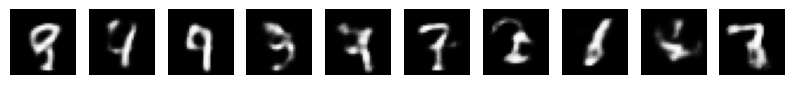

In [2]:
import matplotlib.pyplot as plt

def sample_latent_space(vae, num_samples=10):
    with torch.no_grad():
        # Generate random points in the latent space
        z = torch.randn(num_samples, 50).to(device)  # 50 is the size of the latent space in your VAE

        # Decode these points to generate images
        samples = vae.decode(z).cpu()

        # Reshape the output to image dimensions (for MNIST: 28x28)
        samples = samples.view(num_samples, 28, 28)

        return samples

# Generate samples
num_samples = 10
generated_images = sample_latent_space(vae, num_samples)

# Display the generated images
fig, axes = plt.subplots(1, num_samples, figsize=(10, 2))
for i, ax in enumerate(axes):
    ax.imshow(generated_images[i], cmap='gray')
    ax.axis('off')
plt.show()

#### Changer la dimension de l'espace latent et changer l'architecture du VAE

In [3]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(ConvVAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # 16 x 14 x 14
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # 32 x 7 x 7
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc1 = nn.Linear(32 * 7 * 7, latent_dim)
        self.fc2 = nn.Linear(32 * 7 * 7, latent_dim)

        # Decoder
        self.fc3 = nn.Linear(latent_dim, 32 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (32, 7, 7)),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 16 x 14 x 14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # 1 x 28 x 28
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        return self.fc1(x), self.fc2(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = self.fc3(z)
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

#### Paramétrage de la fonction loss pour pondérer les deux termes (reconstruction et régularisation).

In [4]:
def vae_loss_function(recon_x, x, mu, logvar, recon_weight=1.0, kld_weight=1.0):
    recon_loss = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Weighted sum of the two losses
    total_loss = recon_weight * recon_loss + kld_weight * kld_loss
    return total_loss

# Instantiate and train the ConvVAE
latent_dim = 20
conv_vae = ConvVAE(latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(conv_vae.parameters(), lr=1e-3)

for epoch in range(10):
    conv_vae.train()
    train_loss = 0
    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = conv_vae(data)
        loss = vae_loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset)}')

Epoch 0, Loss: 179.77119777018228
Epoch 1, Loss: 124.9609416829427
Epoch 2, Loss: 119.91755847981771
Epoch 3, Loss: 116.29162351888021
Epoch 4, Loss: 113.72768546549479
Epoch 5, Loss: 111.90022443033854
Epoch 6, Loss: 110.57565550130208
Epoch 7, Loss: 109.4913608561198
Epoch 8, Loss: 108.73025571289062
Epoch 9, Loss: 108.18895148111979


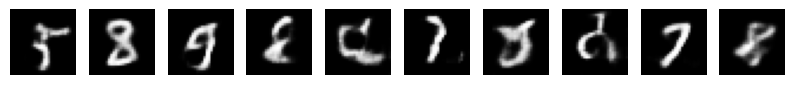

In [5]:
def visualize_latent_space(vae, num_samples=10, latent_dim=20):
    # Sample random vectors from the normal distribution
    z = torch.randn(num_samples, latent_dim).to(device)
    
    # Decode the sample latent vectors
    with torch.no_grad():
        generated_images = vae.decode(z).cpu()
    
    # The output of the decoder will be a flattened vector if your VAE is designed for MNIST
    # So, reshape it back to image size (28x28 for MNIST)
    generated_images = generated_images.view(num_samples, 1, 28, 28)

    # Plot the generated images
    fig, axes = plt.subplots(1, num_samples, figsize=(10, 10))
    for i, ax in enumerate(axes):
        ax.imshow(generated_images[i].squeeze(0), cmap='gray')
        ax.axis('off')
    plt.show()

visualize_latent_space(conv_vae, num_samples=10, latent_dim=latent_dim)